In [1]:
%load_ext autoreload


In [2]:
%autoreload 2

In [3]:
ImageNetMean, ImageNetVariance = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

In [4]:
#IMPORTS
import os 
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.models as models

from pathlib import Path
from typing import *
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader

from utils import *
from datasets.dataset import MiniImageNetDataset

/anaconda/envs/maml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#READ CONFIG
config_dict = json.load(open("./config.json"))

In [6]:
train_classes = []; test_classes = []; val_classes = []
train_classes = os.listdir(config_dict['dataset']['train_path'])
test_classes = os.listdir(config_dict['dataset']['test_path'])
val_classes = os.listdir(config_dict['dataset']['val_path'])

In [7]:
config_dict['train_classes'] = len(train_classes)
config_dict['val_classes'] = len(val_classes)
config_dict['test_classes'] = len(test_classes)
config_dict['train_classes_list_debug'] = train_classes
config_dict['val_classes_list_debug'] = val_classes
config_dict['test_classes_list_debug'] = test_classes
   

In [8]:
print_config(config_dict)
train_class_distrib = class_distribution(config_dict['dataset']['train_path'],config_dict['train_classes_list_debug'])
val_class_distrib = class_distribution(config_dict['dataset']['val_path'],config_dict['val_classes_list_debug'])
test_class_distrib = class_distribution(config_dict['dataset']['test_path'],config_dict['test_classes_list_debug'])


dataset : {'root_path': '/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size', 'train_path': '/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/train', 'test_path': '/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/test', 'val_path': '/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/val'}
model : {'torch_home': '/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Models'}
inner_loop_steps : 4
N_way : 5
K_shot : 5
batch_size : 4
train_classes : 64
val_classes : 16
test_classes : 20


Text(0, 0.5, 'No of Images')

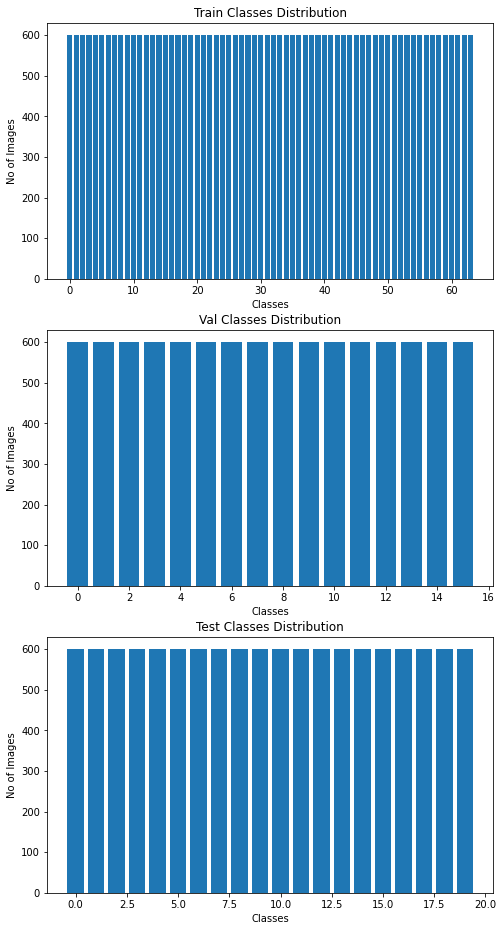

In [9]:
fig = plt.figure(figsize=(8,16))

fig.add_subplot(3,1,1)
plt.bar(list(range(len(train_class_distrib.keys()))), train_class_distrib.values())
plt.title("Train Classes Distribution")
plt.xlabel("Classes")
plt.ylabel("No of Images")


fig.add_subplot(3,1,2)
plt.bar(list(range(len(val_class_distrib.keys()))), val_class_distrib.values())
plt.title("Val Classes Distribution")
plt.xlabel("Classes")
plt.ylabel("No of Images")

fig.add_subplot(3,1,3)
plt.bar(list(range(len(test_class_distrib.keys()))), test_class_distrib.values())
plt.title("Test Classes Distribution")
plt.xlabel("Classes")
plt.ylabel("No of Images")


In [10]:
train_imgs = sample_imgs(config_dict['dataset']['train_path'],config_dict['train_classes_list_debug'],0.1,2)

Image of class type: n06794110


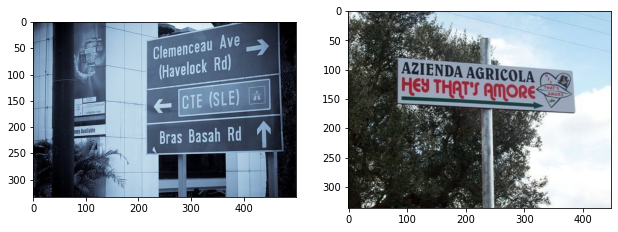

In [11]:
print(f"Image of class type: {list(train_imgs.keys())[0]}")
plot_images_grid(3,3,list(train_imgs.values())[0],figsize=(16,16))

Image of class type: n03854065


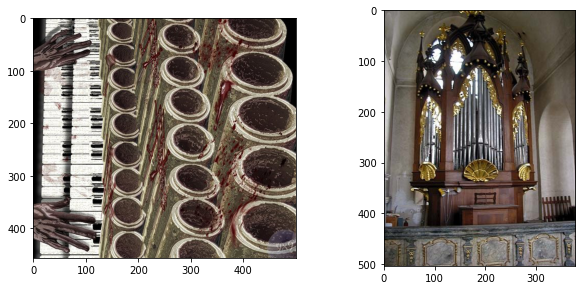

In [12]:
print(f"Image of class type: {list(train_imgs.keys())[1]}")
plot_images_grid(3,3,list(train_imgs.values())[1],figsize=(16,16))

In [13]:
transform = torch.nn.Sequential(
    transforms.Resize((128,128)),
    transforms.Normalize(ImageNetMean,ImageNetVariance)
)

In [14]:

mini_imagenet_dataset_train = MiniImageNetDataset(config_dict['dataset']['train_path'],N_way=5,\
    K_shot=5,query_samples_per_class=2, transform= transform )

No of classes in /home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/train are 64


In [15]:
train_dl = DataLoader(mini_imagenet_dataset_train,batch_size= config_dict['batch_size'],shuffle= True)
val_dl = DataLoader(mini_imagenet_dataset_train,batch_size= config_dict['batch_size'],shuffle= True)

In [16]:
(xs,ys),(xq,yq) = next(iter(train_dl))

In [17]:
xs.shape , ys.shape , xq.shape , yq.shape

(torch.Size([16, 25, 3, 128, 128]),
 torch.Size([16, 25]),
 torch.Size([16, 10, 3, 128, 128]),
 torch.Size([16, 10]))

In [18]:
xs.dtype , ys.dtype

(torch.float32, torch.int64)

In [19]:
torch.max(xs)

tensor(2.6400)

In [20]:
os.environ['TORCH_HOME'] = config_dict['model']['torch_home']
resnet18 = models.resnet18(pretrained=True)

In [21]:
resnet18.fc = torch.nn.Linear(512,5)

In [22]:
resnet18.to("cuda:0")
optim = torch.optim.Adam(resnet18.parameters(), lr = 0.01)
do_train("cuda:0",torch.nn.BCEWithLogitsLoss(),optim,AdamExplicitGrad,resnet18,train_dl,val_dl,config_dict)


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/68 [00:00<?, ?it/s]

Loss iteration: 1 => 1.1002328395843506 with batch size => 16
Accuracy iteration: 1 => 25.625 % with total_preds => 160 


  1%|██████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 1/68 [00:39<43:58, 39.38s/it]

Loss iteration: 2 => 1.1279245615005493 with batch size => 16
Accuracy iteration: 2 => 30.0 % with total_preds => 160 


  3%|████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 2/68 [01:17<42:21, 38.52s/it]

Loss iteration: 3 => 1.101319670677185 with batch size => 16
Accuracy iteration: 3 => 31.25 % with total_preds => 160 


  4%|██████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 3/68 [01:57<42:21, 39.10s/it]

Loss iteration: 4 => 0.812138557434082 with batch size => 16
Accuracy iteration: 4 => 36.875 % with total_preds => 160 


  6%|████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 4/68 [02:37<42:04, 39.45s/it]

Loss iteration: 5 => 0.9861859083175659 with batch size => 16
Accuracy iteration: 5 => 28.75 % with total_preds => 160 


  7%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 5/68 [03:15<41:04, 39.11s/it]

Loss iteration: 6 => 1.0796016454696655 with batch size => 16
Accuracy iteration: 6 => 30.625 % with total_preds => 160 


  9%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 6/68 [03:53<40:06, 38.82s/it]

Loss iteration: 7 => 1.0842974185943604 with batch size => 16
Accuracy iteration: 7 => 31.25 % with total_preds => 160 


 10%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 7/68 [04:32<39:23, 38.75s/it]

Loss iteration: 8 => 1.0610023736953735 with batch size => 16
Accuracy iteration: 8 => 26.875 % with total_preds => 160 


 12%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 8/68 [05:11<38:45, 38.76s/it]

Loss iteration: 9 => 1.0466139316558838 with batch size => 16
Accuracy iteration: 9 => 28.125 % with total_preds => 160 


 13%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 9/68 [05:49<37:53, 38.53s/it]

Loss iteration: 10 => 1.025471806526184 with batch size => 16
Accuracy iteration: 10 => 31.875 % with total_preds => 160 


 15%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 10/68 [06:27<37:07, 38.40s/it]

Loss iteration: 11 => 0.9508090019226074 with batch size => 16
Accuracy iteration: 11 => 32.5 % with total_preds => 160 


 16%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 11/68 [07:05<36:32, 38.47s/it]

Loss iteration: 12 => 1.1315841674804688 with batch size => 16
Accuracy iteration: 12 => 28.125 % with total_preds => 160 


 18%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 12/68 [07:45<36:16, 38.86s/it]

Loss iteration: 13 => 1.088409423828125 with batch size => 16
Accuracy iteration: 13 => 29.375 % with total_preds => 160 


 19%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 13/68 [08:25<35:46, 39.03s/it]

Loss iteration: 14 => 1.1040873527526855 with batch size => 16
Accuracy iteration: 14 => 28.75 % with total_preds => 160 


 21%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 14/68 [09:03<35:03, 38.96s/it]

Loss iteration: 15 => 1.0017179250717163 with batch size => 16
Accuracy iteration: 15 => 31.875 % with total_preds => 160 


 22%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 15/68 [09:42<34:24, 38.96s/it]

Loss iteration: 16 => 0.9599825143814087 with batch size => 16
Accuracy iteration: 16 => 28.125 % with total_preds => 160 


 24%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 16/68 [10:23<34:07, 39.37s/it]

Loss iteration: 17 => 1.0673168897628784 with batch size => 16
Accuracy iteration: 17 => 29.375 % with total_preds => 160 


 25%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 17/68 [11:04<33:53, 39.87s/it]

Loss iteration: 18 => 1.081073522567749 with batch size => 16
Accuracy iteration: 18 => 27.5 % with total_preds => 160 


 26%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 18/68 [11:42<32:53, 39.46s/it]

Loss iteration: 19 => 1.1079128980636597 with batch size => 16
Accuracy iteration: 19 => 26.875 % with total_preds => 160 


 28%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 19/68 [12:21<32:06, 39.33s/it]

Loss iteration: 20 => 1.110038161277771 with batch size => 16
Accuracy iteration: 20 => 27.5 % with total_preds => 160 


 29%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 20/68 [13:00<31:21, 39.21s/it]

Loss iteration: 21 => 1.1625940799713135 with batch size => 16
Accuracy iteration: 21 => 26.875 % with total_preds => 160 


 31%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 21/68 [13:40<30:44, 39.24s/it]

Loss iteration: 22 => 1.104972004890442 with batch size => 16
Accuracy iteration: 22 => 28.125 % with total_preds => 160 


 32%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 22/68 [14:20<30:18, 39.53s/it]

Loss iteration: 23 => 1.0918951034545898 with batch size => 16
Accuracy iteration: 23 => 26.25 % with total_preds => 160 


 34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 23/68 [15:02<30:18, 40.41s/it]

Loss iteration: 24 => 1.2612855434417725 with batch size => 16
Accuracy iteration: 24 => 23.125 % with total_preds => 160 


 35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 24/68 [15:43<29:48, 40.65s/it]

Loss iteration: 25 => 1.1032637357711792 with batch size => 16
Accuracy iteration: 25 => 28.75 % with total_preds => 160 


 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 25/68 [16:23<28:58, 40.43s/it]

Loss iteration: 26 => 1.0201101303100586 with batch size => 16
Accuracy iteration: 26 => 34.375 % with total_preds => 160 


 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 26/68 [17:04<28:18, 40.44s/it]

Loss iteration: 27 => 1.0810151100158691 with batch size => 16
Accuracy iteration: 27 => 32.5 % with total_preds => 160 


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 27/68 [17:46<28:01, 41.01s/it]

Loss iteration: 28 => 1.0990829467773438 with batch size => 16
Accuracy iteration: 28 => 33.75 % with total_preds => 160 


 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 28/68 [18:28<27:30, 41.26s/it]

Loss iteration: 29 => 1.0806885957717896 with batch size => 16
Accuracy iteration: 29 => 31.25 % with total_preds => 160 


 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 29/68 [19:09<26:48, 41.23s/it]

Loss iteration: 30 => 1.0396419763565063 with batch size => 16
Accuracy iteration: 30 => 33.125 % with total_preds => 160 


 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 30/68 [19:51<26:08, 41.28s/it]

Loss iteration: 31 => 1.164864182472229 with batch size => 16
Accuracy iteration: 31 => 32.5 % with total_preds => 160 


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 31/68 [20:32<25:29, 41.35s/it]

Loss iteration: 32 => 1.141403317451477 with batch size => 16
Accuracy iteration: 32 => 27.5 % with total_preds => 160 


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 32/68 [21:12<24:30, 40.86s/it]

Loss iteration: 33 => 1.1221355199813843 with batch size => 16
Accuracy iteration: 33 => 30.0 % with total_preds => 160 


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 33/68 [21:54<23:59, 41.13s/it]

Loss iteration: 34 => 1.0585273504257202 with batch size => 16
Accuracy iteration: 34 => 32.5 % with total_preds => 160 


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 34/68 [22:34<23:14, 41.01s/it]

Loss iteration: 35 => 1.1771200895309448 with batch size => 16
Accuracy iteration: 35 => 28.75 % with total_preds => 160 


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 35/68 [23:16<22:43, 41.32s/it]

Loss iteration: 36 => 1.306350588798523 with batch size => 16
Accuracy iteration: 36 => 30.625 % with total_preds => 160 


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 36/68 [23:57<21:54, 41.07s/it]

Loss iteration: 37 => 1.0124239921569824 with batch size => 16
Accuracy iteration: 37 => 28.125 % with total_preds => 160 


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 37/68 [24:37<21:02, 40.73s/it]

Loss iteration: 38 => 1.030658483505249 with batch size => 16
Accuracy iteration: 38 => 27.5 % with total_preds => 160 


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                        | 38/68 [25:15<19:58, 39.94s/it]

Loss iteration: 39 => 1.2445119619369507 with batch size => 16
Accuracy iteration: 39 => 28.75 % with total_preds => 160 


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                          | 39/68 [25:54<19:13, 39.77s/it]

Loss iteration: 40 => 1.0291990041732788 with batch size => 16
Accuracy iteration: 40 => 37.5 % with total_preds => 160 


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                            | 40/68 [26:34<18:34, 39.82s/it]

Loss iteration: 41 => 1.0089640617370605 with batch size => 16
Accuracy iteration: 41 => 32.5 % with total_preds => 160 


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                              | 41/68 [27:13<17:49, 39.60s/it]

Loss iteration: 42 => 1.113211989402771 with batch size => 16
Accuracy iteration: 42 => 25.0 % with total_preds => 160 


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                               | 42/68 [27:53<17:14, 39.78s/it]

Loss iteration: 43 => 1.0290595293045044 with batch size => 16
Accuracy iteration: 43 => 32.5 % with total_preds => 160 


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                 | 43/68 [28:29<16:03, 38.55s/it]

Loss iteration: 44 => 1.187819004058838 with batch size => 16
Accuracy iteration: 44 => 25.0 % with total_preds => 160 


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                   | 44/68 [29:07<15:17, 38.22s/it]

Loss iteration: 45 => 1.1346499919891357 with batch size => 16
Accuracy iteration: 45 => 27.5 % with total_preds => 160 


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                     | 45/68 [29:47<14:54, 38.88s/it]

Loss iteration: 46 => 1.1938390731811523 with batch size => 16
Accuracy iteration: 46 => 28.75 % with total_preds => 160 


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                       | 46/68 [30:25<14:08, 38.57s/it]

Loss iteration: 47 => 0.9939160943031311 with batch size => 16
Accuracy iteration: 47 => 29.375 % with total_preds => 160 


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 47/68 [31:02<13:23, 38.28s/it]

Loss iteration: 48 => 1.0869832038879395 with batch size => 16
Accuracy iteration: 48 => 33.75 % with total_preds => 160 


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                           | 48/68 [31:40<12:42, 38.10s/it]

Loss iteration: 49 => 0.9758182764053345 with batch size => 16
Accuracy iteration: 49 => 28.75 % with total_preds => 160 


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                            | 49/68 [32:21<12:19, 38.91s/it]

Loss iteration: 50 => 1.09843909740448 with batch size => 16
Accuracy iteration: 50 => 31.25 % with total_preds => 160 


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                              | 50/68 [33:02<11:54, 39.70s/it]

Loss iteration: 51 => 1.0133774280548096 with batch size => 16
Accuracy iteration: 51 => 36.25 % with total_preds => 160 


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                | 51/68 [33:42<11:14, 39.65s/it]

Loss iteration: 52 => 1.1041324138641357 with batch size => 16
Accuracy iteration: 52 => 22.5 % with total_preds => 160 


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                  | 52/68 [34:23<10:40, 40.03s/it]

Loss iteration: 53 => 1.1101120710372925 with batch size => 16
Accuracy iteration: 53 => 27.5 % with total_preds => 160 


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 53/68 [35:02<09:56, 39.79s/it]

Loss iteration: 54 => 0.939845860004425 with batch size => 16
Accuracy iteration: 54 => 29.375 % with total_preds => 160 


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                      | 54/68 [35:40<09:07, 39.13s/it]

Loss iteration: 55 => 0.9115703105926514 with batch size => 16
Accuracy iteration: 55 => 33.125 % with total_preds => 160 


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                        | 55/68 [36:21<08:36, 39.75s/it]

Loss iteration: 56 => 1.0305659770965576 with batch size => 16
Accuracy iteration: 56 => 31.875 % with total_preds => 160 


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 56/68 [37:02<08:00, 40.04s/it]

Loss iteration: 57 => 0.9462053775787354 with batch size => 16
Accuracy iteration: 57 => 35.625 % with total_preds => 160 


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 57/68 [37:42<07:20, 40.06s/it]

Loss iteration: 58 => 1.0479881763458252 with batch size => 16
Accuracy iteration: 58 => 29.375 % with total_preds => 160 


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 58/68 [38:42<06:40, 40.04s/it]


KeyboardInterrupt: 

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
batch_sz, support_sz, C, H, W = xs.shape
outp = resnet18(xs.reshape(-1,C,H,W).cuda())

In [ ]:
outp.device, outp.shape

(device(type='cuda', index=0), torch.Size([50, 5]))